# TP2 : MCMC (Partie 2)

## G3 SDI - Estimation Avancée

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Dans un deuxième exercice, on cherchera à implémenter un échantillonneur de Gibbs dans un modèle de régression linéaire bayésienne.

### Instructions

1. Renommez votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par AMORRI Farah, MILANO Olivia, 09/12/2025.
</div>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Exercice - Bayesian LASSO

Soit le modèle hiérarchique suivant, correspondant à un modèle de régression linéaire bayésienne :
\begin{align}
\sigma^2 & \sim \text{InverseGamma}(a_0, b_0) & \\
\tau_j & \sim \text{InverseGamma} \left(1, \frac{\lambda^2}{2} \right) \qquad & \forall~j \in {1, ..., p} \\
\beta_j | \tau_j, \sigma^2 & \sim \mathcal{N} \left( 0, \frac{\sigma^2}{\tau_j} \right) \qquad & \forall~j \in {1, ..., p} \\
y_i | \boldsymbol{x}_i, \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\boldsymbol{\beta}^{\top} \mathbf{x}_i, \sigma^2) \qquad & \forall~i \in {1, ..., n} \\
\end{align}

On a :
* $y_i \in \mathbb{R}$ la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$ les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$ le vecteur de régression ;
* $\sigma^2$ la variance du bruit.
* $\boldsymbol{\tau} \in \mathbb{R}^p$ une variable latente du modèle.

$\lambda$, $a_0$, et $b_0$ sont quant à eux supposés connus et fixés.
  
Ce modèle s'appelle le *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)) (le .pdf de l'article est dans l'archive). Pour rappel, le LASSO correspond à la régression linéaire pénalisé en norme $\ell_1$.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \boldsymbol{\tau}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi a posteriori à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

On peut trouver les lois conditionnelles dans ce modèle :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1, ..., \tau_p)$.
\begin{align}
\tau_j | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InverseGaussian}\left( \frac{\lambda \sigma}{\beta_j}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> voir [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{InverseGamma}\left( a_0 + \frac{n+p}{2},~b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \boldsymbol{\beta}^{\top} \mathbf{D}_{\tau} \boldsymbol{\beta}  \right).
\end{align}

In [3]:
# Dataset

from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X = X*np.sqrt(442) # Standardize, X is already centered
y = (y-np.mean(y))/np.std(y) # Zero-mean output, as no intercept in the model for simplicity

print(X.shape)

(442, 10)


**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$ ;
* Le nombre d'échantillons après burn-in $N_g$ ;
* La taille du *burn-in* $N_b$ ;
* Les hyperparamètres du modèle : $a_0,~b_0,~\lambda$.

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \boldsymbol{\tau}, \sigma^2 | \mathcal{D})$. On pourra initialiser la chaîne en tirant de la loi a priori.

NB :
* Pour échantillonner d'une loi inverse gamma (a,b), on pourra utiliser `invgamma.rvs(a, loc=0, scale=b)`
* Pour échantillonner d'une loi inverse gaussian (m,l), on pourra utiliser `invgauss.rvs(m/l, loc=0, scale=l)`

In [4]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):

    n = X.shape[0]
    p = X.shape[1]
    sigma0 = ss.invgamma.rvs(a0, loc=0, scale=b0)
    tau0 = ss.invgamma.rvs(1, loc=0, scale=l**2/2, size=p)

    sigma = sigma0
    tau = tau0
    beta=None

    beta_list = [np.zeros(p)]
    sigma_list = [sigma0]
    tau_list = [tau0]



    for j in range(Nb+Ng):
        
        #BETA 
        #Calcul de A = (X.T@X+Dtau) avec Dtau = diag(tau)
        Dtau = np.diag(tau)
        A = np.linalg.inv(X.T@X+Dtau)
        beta = ss.multivariate_normal.rvs(A@X.T@y, sigma*A)

        #TAU
        new_tau = []
        for i in range(p):
            tau_i = ss.invgauss.rvs((l*np.sqrt(sigma)/np.abs(beta[i])))
            new_tau.append(tau_i)
        tau = np.array(new_tau)
        Dtau = np.diag(tau)

        #SIGMA 
        first_term = a0 + (n+p)/2
        second_term = b0 + (1/2)* (np.linalg.norm(y - (X @ beta), ord=None, axis=None, keepdims=False))**2 + (1/2)*beta.T@Dtau@beta
        sigma = ss.invgamma.rvs(a=first_term, scale=second_term)

        beta_list.append(beta)
        sigma_list.append(sigma)
        tau_list.append(tau.copy())
    
    return np.array(beta_list), np.array(sigma_list), np.array(tau_list)
        



**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = 2000$, $N_b = 1000$, $a_0 = 1.5$, $b_0 = 1$, $\lambda = 10$.

* Afficher les *traceplots* pour $\sigma^2$ et quelques-uns des $\beta_p$. Commenter
* Pour tous les $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE. Enfin, donner l'intervalle de crédibilité à 95%.


In [5]:
Ng = 2000
Nb = 1000
a0 = 1.5
b0 = 1
l = 10


beta, sigma, tau = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)

print(beta.shape)




(3001, 10)


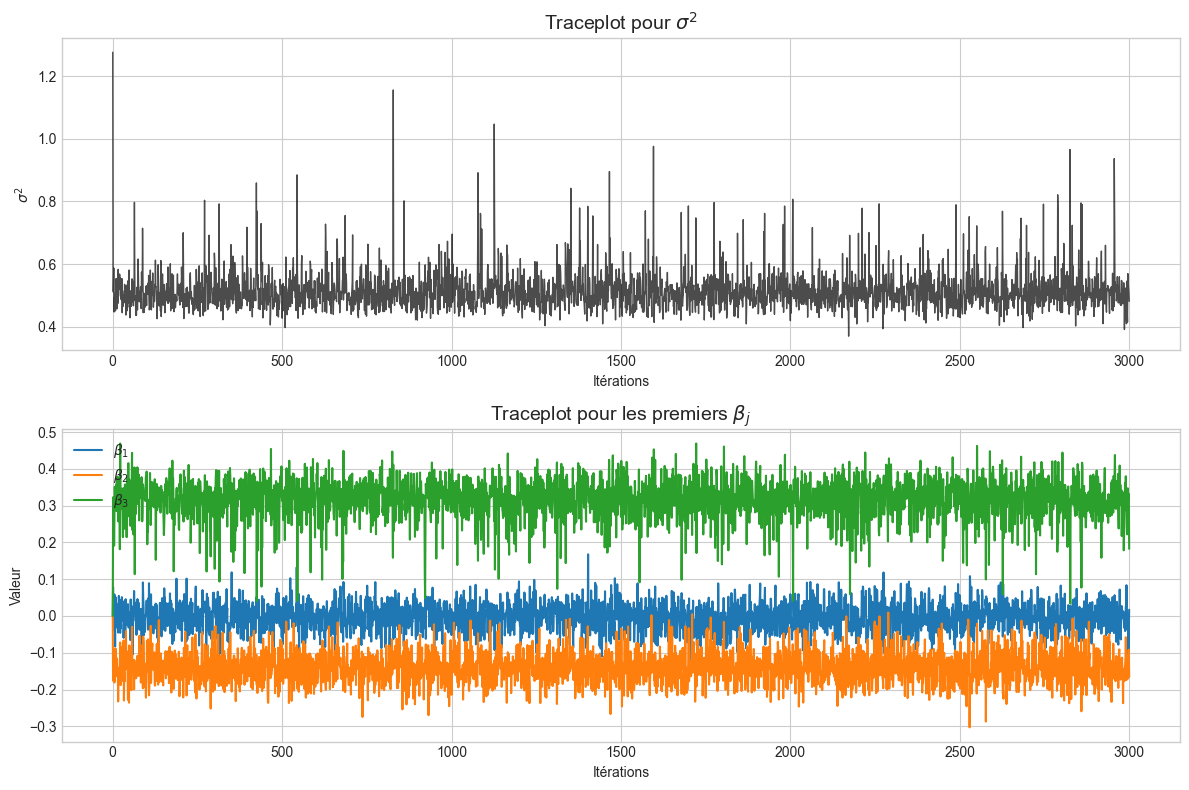

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Paramètres de style (optionnel)
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Traceplots ---
plt.figure(figsize=(12, 8))

# Traceplot pour Sigma^2
plt.subplot(2, 1, 1)
plt.plot(sigma, color='black', lw=1, alpha=0.7)
plt.title(r'Traceplot pour $\sigma^2$', fontsize=14)
plt.xlabel('Itérations')
plt.ylabel(r'$\sigma^2$')

# Traceplot pour quelques Beta (par exemple les 3 premiers)
plt.subplot(2, 1, 2)
# On prend min(p, 3) pour ne pas planter si p < 3
p = beta.shape[1]
n_betas_to_plot = min(p, 3) 

for j in range(n_betas_to_plot):
    plt.plot(beta[:, j], label=r'$\beta_{' + str(j+1) + '}$')

plt.title(r'Traceplot pour les premiers $\beta_j$', fontsize=14)
plt.xlabel('Itérations')
plt.ylabel('Valeur')
plt.legend()

plt.tight_layout()
plt.show()


### Analyse des Traceplots

Les figures ci-dessus représentent l'évolution des paramètres $\sigma^2$ et des premiers coefficients $\beta_j$ (pour $j=1, 2, 3$) au cours des itérations de l'échantillonneur de Gibbs. L'axe des abscisses représente le nombre d'itérations (ici 3000, ce qui correspond à la somme $N_b + N_g$).

**1. Convergence et Stationnarité :**
* L'aspect visuel des courbes est satisfaisant : stable autour d'une valeur moyenne constante.
* Il n'y a pas de tendance visible (pas de *drift*) à la hausse ou à la baisse, ce qui indique que la chaîne a atteint sa distribution stationnaire (le posterior).
* Le fait que les signaux soient stables dès les premières itérations visibles suggère que la période de *burn-in* ($N_b = 1000$) a été suffisante pour "oublier" l'initialisation et atteindre la zone de haute probabilité du posterior.

**2. Qualité du mélange (Mixing) :**
* Les chaînes semblent bien explorer l'espace des paramètres. On observe des fluctuations rapides autour de la moyenne, ce qui est le signe d'une **faible autocorrélation** entre les itérations successives (le mélange est bon).
* Pour **$\sigma^2$** (graphique du haut), on remarque quelques pics isolés (valeurs allant jusqu'à 1.2), mais la chaîne revient rapidement vers sa masse principale (autour de 0.5 - 0.6). Ce comportement est classique pour des paramètres de variance.

**3. Séparation des coefficients $\beta$ :**
* Le graphique du bas montre que les distributions marginales des coefficients sont bien distinctes :
    * $\beta_3$ (en vert) oscille autour de $0.30$.
    * $\beta_1$ (en bleu) oscille autour de $0.0$.
    * $\beta_2$ (en orange) oscille autour de $-0.15$.
* Cette séparation claire confirme que le modèle arrive à identifier des rôles différents pour chaque variable explicative.

---

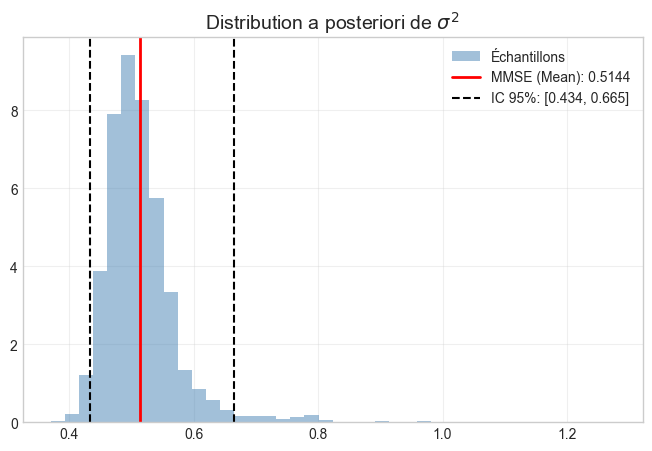

--- Distribution a posteriori de $\sigma^2$ ---
MMSE : 0.51443
IC 95% : [0.43413, 0.66478]



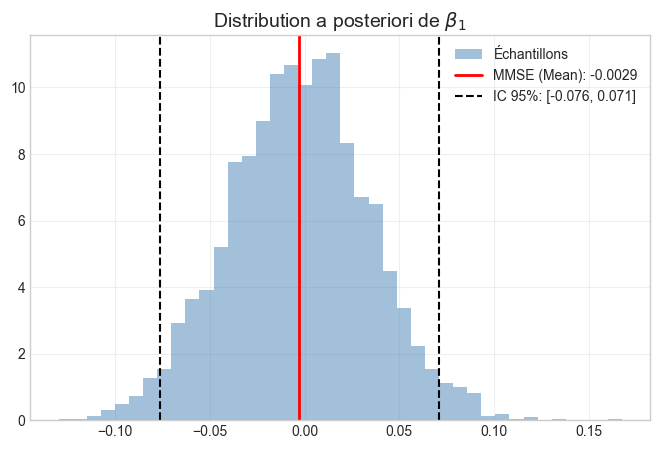

--- Distribution a posteriori de $\beta_{1}$ ---
MMSE : -0.00285
IC 95% : [-0.07650, 0.07122]



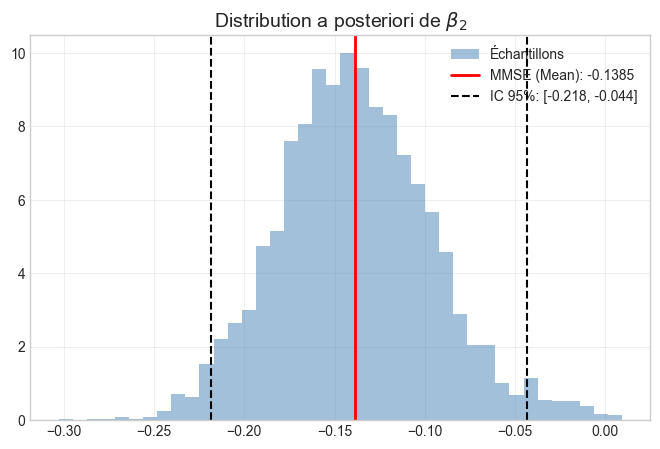

--- Distribution a posteriori de $\beta_{2}$ ---
MMSE : -0.13846
IC 95% : [-0.21837, -0.04365]



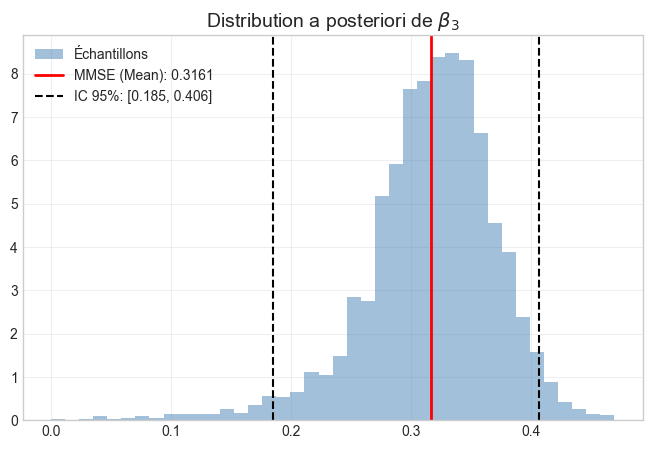

--- Distribution a posteriori de $\beta_{3}$ ---
MMSE : 0.31612
IC 95% : [0.18517, 0.40585]



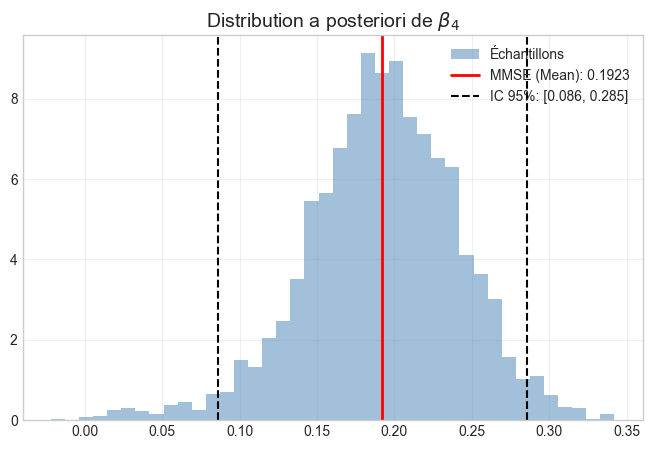

--- Distribution a posteriori de $\beta_{4}$ ---
MMSE : 0.19230
IC 95% : [0.08597, 0.28545]



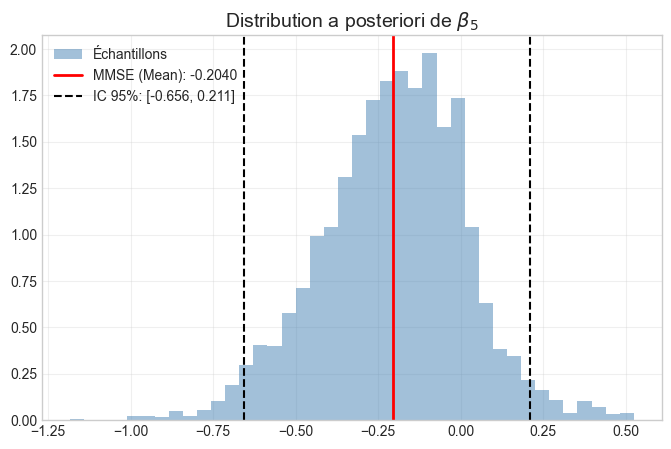

--- Distribution a posteriori de $\beta_{5}$ ---
MMSE : -0.20405
IC 95% : [-0.65595, 0.21083]



In [7]:

def plot_posterior(samples, title_text):
    """
    Fonction utilitaire pour tracer l'hist/KDE et afficher les stats
    """

    mmse = np.mean(samples)
    ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])
    

    plt.figure(figsize=(8, 5))
    

    plt.hist(samples, bins=40, density=True, alpha=0.5, color='steelblue', label='Échantillons')
    

    plt.axvline(mmse, color='red', linewidth=2, label=f'MMSE (Mean): {mmse:.4f}')
    plt.axvline(ci_lower, color='black', linestyle='--', label=f'IC 95%: [{ci_lower:.3f}, {ci_upper:.3f}]')
    plt.axvline(ci_upper, color='black', linestyle='--')
    
    plt.title(title_text, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    

    print(f"--- {title_text} ---")
    print(f"MMSE : {mmse:.5f}")
    print(f"IC 95% : [{ci_lower:.5f}, {ci_upper:.5f}]\n")

# Sigma^2
plot_posterior(sigma, r'Distribution a posteriori de $\sigma^2$')

#  Beta 
for j in range(min(p, 5)): 
    plot_posterior(beta[:, j], r'Distribution a posteriori de $\beta_{' + str(j+1) + '}$')



<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Votre réponse ici
</div>

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

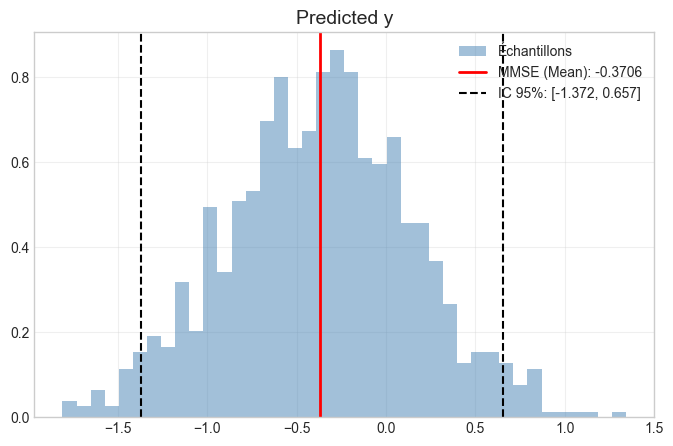

In [8]:
N = 1000
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])

beta_predictive = np.array([np.mean(beta[:,j]) for j in range(p)])
sigma_predictive = np.mean(sigma)

y_list = []
for i in range(N):
       y_sample = ss.norm.rvs(beta_predictive.T@x_new, sigma_predictive)
       y_list.append(y_sample)
y_list=np.array(y_list)

mmse = np.mean(y_list)
ci_lower, ci_upper = np.percentile(y_list, [2.5, 97.5])


plt.figure(figsize=(8, 5))


plt.hist(y_list, bins=40, density=True, alpha=0.5, color='steelblue', label='Échantillons')


plt.axvline(mmse, color='red', linewidth=2, label=f'MMSE (Mean): {mmse:.4f}')
plt.axvline(ci_lower, color='black', linestyle='--', label=f'IC 95%: [{ci_lower:.3f}, {ci_upper:.3f}]')
plt.axvline(ci_upper, color='black', linestyle='--')

plt.title("Predicted y", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Votre réponse ici
</div>

**Q4.** Étudier l'influence du paramètre $\lambda$ sur l'inférence des paramètres (prendre e.g. $\lambda = 1$ et $\lambda=100$). Commenter.

Simulation lambda = 1...
Simulation lambda = 100...


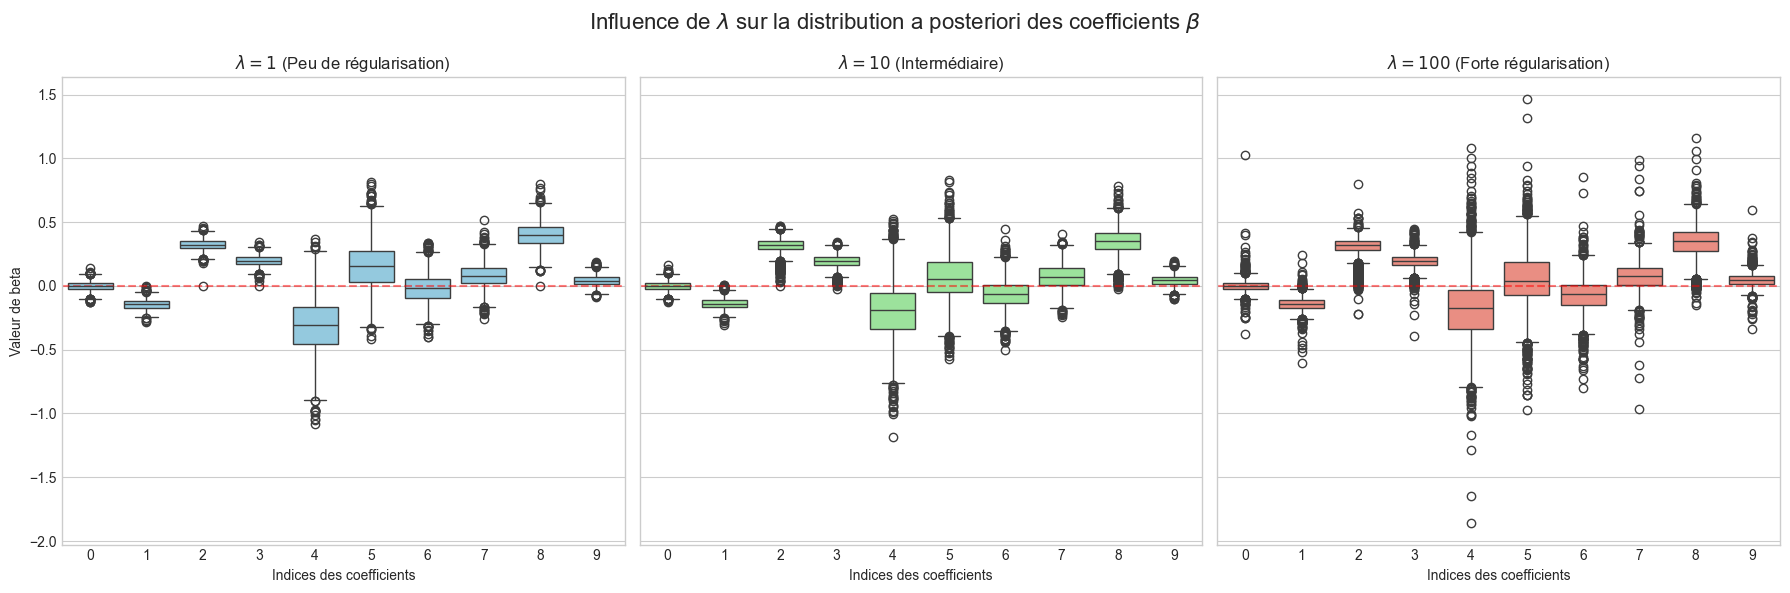

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Lancer les simulations
# On suppose que tu as déjà les données X, y, a0, b0, Ng, Nb
print("Simulation lambda = 1...")
beta_1, _, _ = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l=1)

print("Simulation lambda = 100...")
beta_100, _, _ = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l=100)

# (Tu as déjà beta_10 issu de la question précédente, sinon relance-le)
# beta_10, _, _ = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l=10)


# 2. Visualisation comparative
# On va tracer les Boxplots des coefficients pour voir comment ils "rétrécissent"
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Lambda = 1
sns.boxplot(data=beta_1, ax=axes[0], color='skyblue')
axes[0].set_title(r'$\lambda = 1$ (Peu de régularisation)')
axes[0].set_xlabel('Indices des coefficients')
axes[0].set_ylabel('Valeur de beta')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)

# Lambda = 10 (Récupère ton résultat de Q2 ici)
# Si tu as appelé ton résultat précédent "beta", utilise-le ici
sns.boxplot(data=beta, ax=axes[1], color='lightgreen') 
axes[1].set_title(r'$\lambda = 10$ (Intermédiaire)')
axes[1].set_xlabel('Indices des coefficients')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)

# Lambda = 100
sns.boxplot(data=beta_100, ax=axes[2], color='salmon')
axes[2].set_title(r'$\lambda = 100$ (Forte régularisation)')
axes[2].set_xlabel('Indices des coefficients')
axes[2].axhline(0, color='red', linestyle='--', alpha=0.5)


plt.suptitle(r"Influence de $\lambda$ sur la distribution a posteriori des coefficients $\beta$", fontsize=16)
plt.tight_layout()
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Votre réponse ici
</div>